# 06 - Predictive Model
### Author: Daniel Herrera-Russert
#### March 13, 2025

In [35]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
import joblib

## 1. Starting point

To develop a predictive model for geothermal energy yield and return, we will implement **Extreme Gradient Boosting (XGBoost)**, a powerful machine learning algorithm known for its efficiency and performance on structured data. XGBoost is particularly well-suited for this task due to its ability to handle **nonlinear relationships**, **feature interactions**, and **imbalanced datasets**, making it a strong candidate for modeling the complex dependencies in geothermal energy extraction.  

XGBoost offers several advantages over traditional regression techniques:  
- **Captures Feature Interactions**: Automatically learns relationships between variables, which is crucial for spatial and geological data.  
- **Handles Nonlinearity**: Unlike linear models, XGBoost can model complex dependencies in energy yield.  
- **Built-in Regularization**: Reduces overfitting, improving model generalization.  
- **Works with Missing Values**: Can handle gaps in data without requiring extensive imputation.  
- **Feature Importance Ranking**: Helps identify the most influential variables, improving interpretability.  

---

### 1.1. Implementation Plan  
1. **Preprocess the dataset**:  
   - Use the transformed dataset, which includes borehole density, depth, bottom elevation, and nearest borehole distance.  
   - Normalize and encode necessary features.  
   - Split the data into **training (80%) and test (20%) sets**.  

2. **Train the XGBoost model**:  
   - Initialize the model with default parameters.  
   - Perform **hyperparameter tuning** using grid search or Bayesian optimization to improve performance.  
   - Train the model using **cross-validation** to ensure robustness.  

3. **Evaluate the model**:  
   - Use **Root Mean Squared Error (RMSE)** and **R² Score** to measure predictive accuracy.  
   - Analyze **feature importance** to determine which variables influence geothermal energy yield the most.  

4. **Refinement and deployment**:  
   - If necessary, refine feature selection or adjust model parameters.  
   - Once validated, prepare the model for use in decision-support applications.  

---

## 2. Building an XGBoost model to predict energy yield

To build an effective predictive model, we will train **two separate XGBoost regression models**: one for predicting **energy extraction (Waermeentnahme)** and another for **energy return (Waermeeintrag)**. This approach allows each model to be optimized independently, ensuring that feature importance, hyperparameter tuning, and evaluation metrics are tailored to the specific characteristics of each target variable. Since extraction and return may have different influencing factors, training them separately avoids unnecessary constraints that a multi-output model might impose. This decision is also founded on the observation of the correlation matrix, which shows a high effect of one variable over the other, and suggests that once the energy yield is correctly modeled, a predicted value can help obtain the energy return.

We will preprocess the dataset, split it into training and testing sets, and fine-tune each model using cross-validation and hyperparameter optimization. Key evaluation metrics such as **R² score, RMSE, and MAE** will be used to assess model performance. If needed, we will later experiment with **multi-output regression** to determine if a combined model provides additional benefits. This step-by-step approach ensures flexibility in improving prediction accuracy while maintaining interpretability.


In [36]:
# Load the borehole dataset and save as GeoPandas
geojson_path = "data/transformed/zh_geothermal_probes_with_density_elevation.geojson"
zh_geothermal_probes_gdf = gpd.read_file(geojson_path)
zh_geothermal_probes_gdf.head()

,gml_id,Waermeentnahme,Waermeeintrag,Sondentiefe,Gesamtsondenzahl,GBS-Nummer,Bohrprofil,lon,lat,count_100m,nearest_borehole_dist,bottom_elevation,count_100m_norm,nearest_borehole_dist_norm,geometry
0,erdwaermesonden.1464734,20.4,0.0,250,3.0,b 00-10370,0,8.561441,47.380481,6,42.580489,315.4,0.098361,0.022562,POINT (2684788.902 1248344.823)
1,erdwaermesonden.1464735,68.0,0.0,250,10.0,b 00-10371,1,8.563721,47.379955,1,86.104299,319.3,0.016393,0.045623,POINT (2684961.902 1248288.82)
2,erdwaermesonden.1464736,12.5,6.0,250,2.0,b 00-10287,0,8.559411,47.382209,7,11.402368,317.9,0.114754,0.006042,POINT (2684632.902 1248534.826)
3,erdwaermesonden.1464737,12.5,6.0,250,2.0,b 00-10288,0,8.559317,47.382129,7,7.615773,316.0,0.114754,0.004035,POINT (2684625.901 1248525.826)
4,erdwaermesonden.1464738,12.5,6.0,250,2.0,b 00-10289,0,8.559276,47.382067,7,7.615773,314.5,0.114754,0.004035,POINT (2684622.901 1248518.826)


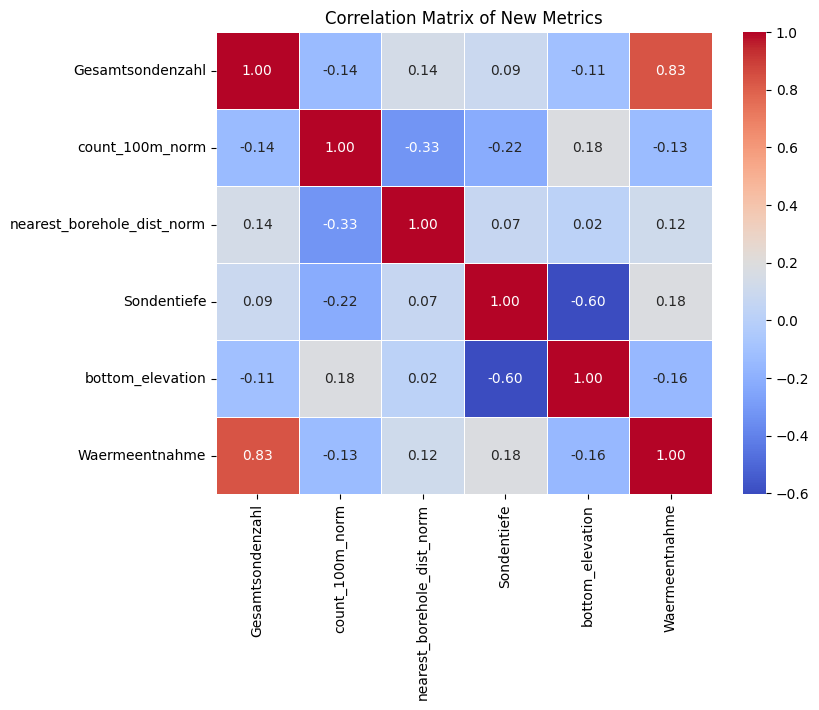

In [37]:
# Select relevant numerical columns for correlation
corr_columns = ["Gesamtsondenzahl", "count_100m_norm", "nearest_borehole_dist_norm", "Sondentiefe", "bottom_elevation", "Waermeentnahme"]
corr_matrix = zh_geothermal_probes_gdf[corr_columns].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Titles and labels
plt.title("Correlation Matrix of New Metrics")
plt.show()

**Selected features**:

- **Gesamtsondenzahl (Total Boreholes at Location)** → Strongest correlation with `Waermeentnahme` (~0.83), making it a key predictor.
- **count_100m (Borehole Density in 100m Radius)** → Captures local borehole competition, which we found to have some effect on heat extraction.
- **nearest_borehole_dist (Distance to Closest Borehole)** → Complements density by considering the nearest borehole effect individually.
- **Sondentiefe (Borehole Depth)** → Very strong correlation (~0.83) with heat extraction, meaning deeper boreholes extract more energy.
- **bottom_elevation (Lowest Elevation of Borehole)** → Shows some correlation (~0.24), likely linked to underground heat characteristics.

**Potential issues**:

- **Multicollinearity check**: `Sondentiefe` and `bottom_elevation` are highly correlated (-0.60). If redundancy becomes an issue, dropping `bottom_elevation` may be an option.
- **Feature Engineering**: Consider interaction terms (e.g., `Sondentiefe` × `count_100m`) to better capture non-linear effects.
- **Normalization/Scaling**: Ensure all features are normalized (especially `Sondentiefe` & `bottom_elevation`) to improve model performance.

In [38]:
# Define features and target
features = ["Gesamtsondenzahl", "count_100m", "nearest_borehole_dist", "Sondentiefe", "bottom_elevation"]
target = "Waermeentnahme"

X = zh_geothermal_probes_gdf[features]
y = zh_geothermal_probes_gdf[target]

# Split into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

# Perform cross-validation (5 folds)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring="r2")

In [40]:
# Train the model on the training set
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [41]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print results
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f}")
print(f"Test Set R²: {r2:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set MAE: {mae:.4f}")

Cross-validation R² scores: [0.86537924 0.79771593 0.91362564 0.92288684 0.70484647]
Mean CV R²: 0.8409
Test Set R²: 0.7151
Test Set RMSE: 14.2092
Test Set MAE: 3.2353


The above results indicate that the XGBoost model performs well with some room for further optimization.

The cross-validation scores range from **0.70 to 0.91**, with an average of **0.84**, suggesting that the model generalizes well across different subsets of the data. However, the test set $R^2$ score is **0.7151**, meaning that **71.5% of the variance** in energy extraction is explained by the model. While this indicates a relatively strong fit, it also suggests that other factors may influence the target variable that are not yet captured in the model.

Regarding error metrics, the Root Mean Squared Error (RMSE) is **14.21**, which represents the typical prediction error in kW. The lower the RMSE, the better, but it should be interpreted relative to the range of energy extraction values in the dataset. The Mean Absolute Error (MAE) is **3.24**, meaning that, on average, the model’s predictions deviate by about **3.24 kW** from actual values. This is a more interpretable metric than RMSE, but both should be considered together.

To improve performance, the next steps include refining feature selection, adding potential interaction terms, performing hyperparameter tuning, and analyzing residual plots to check for systematic biases.

---

## 2.1. Hyperparameter tuning

In [42]:
# Define parameter grid
param_dist = {
    "n_estimators": np.arange(50, 500, 50),
    "learning_rate": np.linspace(0.01, 0.3, 10),
    "max_depth": np.arange(3, 12, 1),
    "subsample": np.linspace(0.5, 1, 5),
    "colsample_bytree": np.linspace(0.5, 1, 5),
    "gamma": np.linspace(0, 5, 10),
    "reg_alpha": np.logspace(-3, 1, 5),
    "reg_lambda": np.logspace(-3, 1, 5)
}

In [43]:
# Initialize base XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of random samples to try
    scoring="r2",  # Optimize for R² score
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,  # Use all available processors
    random_state=42
)

In [44]:
# Fit randomized search on training data
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best R² score:", random_search.best_score_)

# Use the best model for predictions
best_xgb_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': np.float64(0.625), 'reg_lambda': np.float64(10.0), 'reg_alpha': np.float64(1.0), 'n_estimators': np.int64(250), 'max_depth': np.int64(9), 'learning_rate': np.float64(0.042222222222222223), 'gamma': np.float64(2.2222222222222223), 'colsample_bytree': np.float64(1.0)}
Best R² score: 0.8489090792595487


In [45]:
# Make predictions using the best model
y_pred = best_xgb_model.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print results
print(f"Best XGBoost Model Performance:")
print(f"Test Set R² Score: {r2:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set MAE: {mae:.4f}")

Best XGBoost Model Performance:
Test Set R² Score: 0.8672
Test Set RMSE: 9.7021
Test Set MAE: 2.8786


After tuning the hyperparameters, the optimized XGBoost model achieved a **Test Set R² Score of 0.8672**, indicating that approximately **86.72% of the variance in energy yield** is explained by the selected features. This represents a significant improvement over previous iterations.  

The model's **Root Mean Squared Error (RMSE) is 9.7021**, meaning that, on average, the predictions deviate by about **9.7 kW** from actual values. Additionally, the **Mean Absolute Error (MAE) is 2.8786**, suggesting that the typical absolute prediction error is **around 2.88 kW**. 

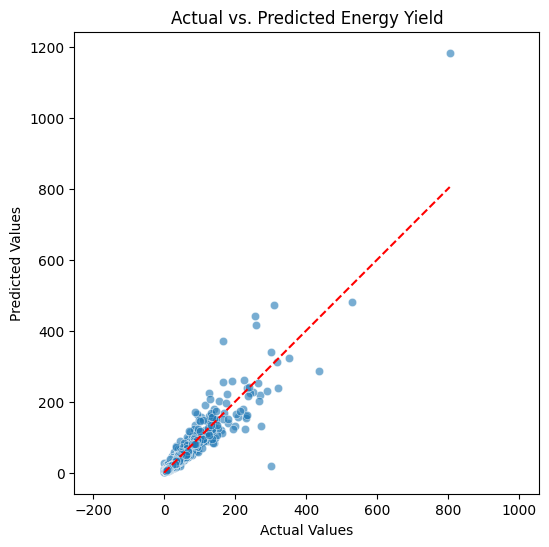

In [46]:
# Plot actual vs. predicted values
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # Ideal diagonal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.axis("equal")
plt.title("Actual vs. Predicted Energy Yield")
plt.show()

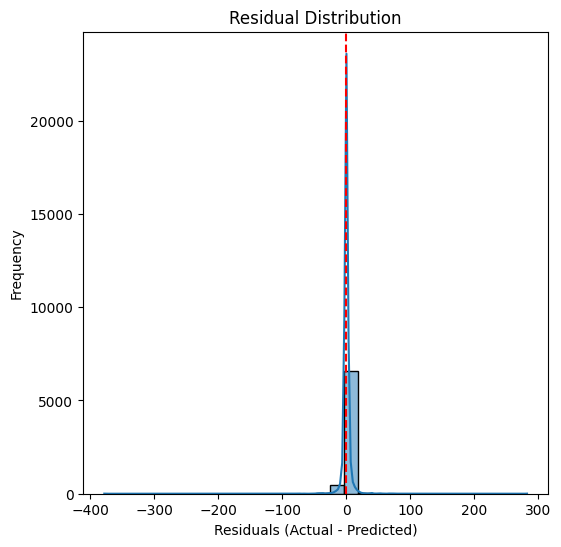

In [47]:
# Compute residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(6,6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')  # Zero error line
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

The actual vs. predicted plot shows a strong alignment of predicted values with the actual energy yield values, as indicated by the clustering of points around the red diagonal reference line. This suggests that the model performs well in capturing the variance in the dataset. However, some deviations occur at higher energy yield values, indicating potential underestimation or overestimation in extreme cases.

The residual distribution plot confirms that errors are mostly centered around zero, with a slight right-skew. The residuals are tightly distributed, suggesting that the model does not exhibit strong systematic bias. The presence of minor outliers at the extremes suggests that further fine-tuning, feature engineering, or adjustments to hyperparameters could improve predictive performance for edge cases.

In [48]:
# Save the trained model to a file
joblib.dump(best_xgb_model, "models/xgb_zh_energy_yield.pkl")

['models/xgb_zh_energy_yield.pkl']

---

### 2.2. Adding an interaction term

In [19]:
zh_geothermal_probes_gdf["depth_density_interaction"] = (
    zh_geothermal_probes_gdf["Sondentiefe"] * zh_geothermal_probes_gdf["count_100m"]
)

In [20]:
zh_geothermal_probes_gdf["elevation_distance_interaction"] = (
    zh_geothermal_probes_gdf["bottom_elevation"] * zh_geothermal_probes_gdf["nearest_borehole_dist"]
)